In [6]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
from IPython.display import display, Latex
from sklearn.cluster import KMeans

from utils.data_management import check_constraints, load_data
from utils import regularization_benefit

from models import model_selection
from models import DictionaryLearning

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg

from datetime import date, timedelta

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import IFrame
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data

In [9]:
P = load_data()
pd.DataFrame(P)

,0,1,2,3,4,5,6,7,8,9,...,182,183,184,185,186,187,188,189,190,191
0,0.767199,0.767205,0.736855,0.748747,0.748338,0.771916,0.756948,0.904350,0.903882,0.903974,...,0.832057,0.803909,0.810724,0.767708,0.772607,0.766515,0.749932,0.734179,0.763076,0.778180
1,0.050118,0.055954,0.054800,0.052730,0.052412,0.063683,0.042119,0.041471,0.049926,0.048222,...,0.007518,0.007206,0.000000,0.001292,0.001327,0.001332,0.001248,0.001245,0.001239,0.000000
2,0.000561,0.000547,0.001595,0.001563,0.001525,0.014756,0.013023,0.012899,0.012411,0.012479,...,0.002459,0.000652,0.000641,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,0.006975,0.006991,0.006832,0.006331,0.006306,0.006298,0.000000,0.000000,0.000000,0.000000,...,0.003521,0.003357,0.003591,0.002997,0.002923,0.002934,0.002941,0.003057,0.003068,0.002039
106,0.006737,0.006714,0.006634,0.007171,0.007151,0.007044,0.009697,0.004770,0.004725,0.004799,...,0.005506,0.004808,0.004692,0.004769,0.005557,0.007287,0.003980,0.008255,0.008245,0.006730
107,0.006235,0.006211,0.006286,0.006285,0.006299,0.006283,0.022471,0.022233,0.022326,0.022156,...,0.039539,0.039025,0.019506,0.013968,0.011628,0.011542,0.011345,0.011883,0.011612,0.008743
108,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.022627,0.023380,0.023310,0.023939,...,0.275891,0.292345,0.238223,0.250439,0.166759,0.166804,0.147356,0.146453,0.149397,0.088947


In [10]:
check_constraints(data=P)

Inequality constraints unsatisfied: 67 (31.90%)
Equality constraints unsatisfied: 0 (0.00%)


In [11]:
# sparsity coefficient
np.count_nonzero(P)/(P.shape[0] * P.shape[1])

0.6025568181818182

In [12]:
# example of the first matrix P^t
pd.DataFrame(P[:, 0].reshape(10,11,order='F'), columns=np.arange(1,12), index=np.arange(1,11))

,1,2,3,4,5,6,7,8,9,10,11
1,0.767199,0.092597,0.000000,0.124510,0.000000,0.000000,0.000000,0.015694,0.000000,0.000000,0.000000
2,0.050118,0.819182,0.052280,0.047432,0.015789,0.015199,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000561,0.157136,0.667078,0.104888,0.012873,0.042320,0.000561,0.014583,0.000000,0.000000,0.000000
4,0.000000,0.027381,0.185256,0.682890,0.048760,0.039520,0.000815,0.004597,0.010780,0.000000,0.000000
5,0.000000,0.005614,0.029237,0.150391,0.661307,0.134347,0.006675,0.011803,0.000626,0.000000,0.000000
6,0.001082,0.001680,0.001651,0.021039,0.131511,0.719877,0.076555,0.026657,0.003340,0.009632,0.006975
7,0.000000,0.000000,0.000000,0.000427,0.014601,0.113097,0.749324,0.091771,0.018397,0.005646,0.006737
8,0.000000,0.000000,0.000587,0.009089,0.000000,0.032222,0.082259,0.852709,0.014197,0.002701,0.006235
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.009362,0.037446,0.178637,0.738490,0.036065,0.000000
10,0.000000,0.000000,0.000000,0.000000,0.039409,0.000000,0.295019,0.000000,0.020525,0.608648,0.036398


In [13]:
# dates
sdate = date(2004, 1, 1)   # start date
edate = date(2020, 1, 1)   # end date

dates = pd.date_range(sdate,edate, freq='m')  # -timedelta(days=30)
dates

DatetimeIndex(['2004-01-31', '2004-02-29', '2004-03-31', '2004-04-30',
               '2004-05-31', '2004-06-30', '2004-07-31', '2004-08-31',
               '2004-09-30', '2004-10-31',
               ...
               '2019-03-31', '2019-04-30', '2019-05-31', '2019-06-30',
               '2019-07-31', '2019-08-31', '2019-09-30', '2019-10-31',
               '2019-11-30', '2019-12-31'],
              dtype='datetime64[ns]', length=192, freq='M')

**DL Model**
\begin{equation}
\label{eq:L2-reg} 
\min_{\mathbf D,\mathbf A, \mathbf w} ~ \|\mathbf P - \mathbf D\mathbf A\|_{\tt{F}}^2 + \lambda\sum_{k=1}^K\sum_{t =1}^{T-1} \left(\alpha_{k}^{t+1} - \bar\alpha_k - w_k(\alpha_{k}^{t}-\bar\alpha_k)\right)^2 .
\end{equation}
st
\begin{align}
    &\mathbf D \in \mathcal \Omega\\
    & \alpha_k^t \geq0, \text{ for all } t=1,\dots,T \text{ and } k=1,\dots,K,\\
\end{align}
with 
$$\bar\alpha_k = \frac{1}{T}\sum_{t=1}^T\alpha_k^t$$

**AR Model**
$$\alpha_{k}^{t+1} = \bar\alpha_k + w_k(\alpha_{k}^{t}-\bar\alpha_k) + \epsilon^t_k$$
with 
$$\epsilon^t_k\sim\mathcal N\left(0, Var[\alpha_k](1-w_k^2)\right)$$

# Lags selection

Plot the Partial Autocorrelation between the $(\alpha^t_\cdot)_t$ representing the correlation between the observations at the current and the previous time. We expect to retrieve a Lag of 1 similar to the AR1 model on $(Z_t)_t$.

[REF]: Box, G. E. P.; Jenkins, G. M.; Reinsel, G. C. (2008). Time Series Analysis, Forecasting and Control (4th ed.). Hoboken, NJ: Wiley. ISBN 9780470272848. Chapter 3.2

- Le test AR donne toujours 1 Lag !

In [88]:
N_MAT = P.shape[1]
n_test = int(0.2 * N_MAT)
P_test = P[:, -int(n_test):]
n_train = int(N_MAT-n_test)
P_train = P[:, :int(N_MAT-n_test)]

K=2

model = DictionaryLearning(K=K, r_dim=11)
model.fit(P_train, lamb=0., max_iter=500)

/opt/homebrew/Caskroom/miniforge/base/envs/cvxopt/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/cvxopt/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


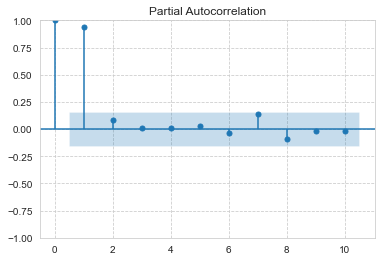

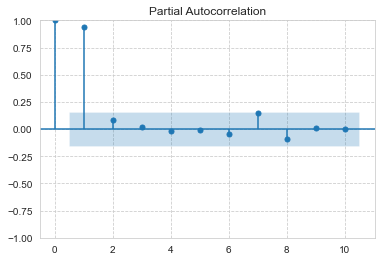

In [89]:
for k in range(2):
    _=plot_pacf(x=model.A[k, :], lags=10)

It validates our assumption to use a AR1 model in the regularization term

# Reconstruction / Regularizatioin / Objective
Study for different values of $\lambda$

In [26]:
def cross_lambda_training(P, K, r_dim, n_mat, max_iter=100):
    """
    DL training for several lambdas
    Parameters
    ----------
    P : ndarray
        migration matrices
    K: int
        number of atoms
    r_dim: int
        matrix dimenion
    n_mat: int
        number of matrices
    max_iter: int
        DL iterations

    
    Returns
    -------
    dict_reco:  dict
    dict_regu:  dict
    dict_obj:  dict
    """
    dict_reco = {}
    dict_regu = {}
    dict_obj = {}
    dict_codings = {}
    LIST_LAMBDAS = [0.01, 0.1, 0.25, 0.5, 0.75, 0.9]
    for lamb in LIST_LAMBDAS:
        # fit
        model = DictionaryLearning(K=K, r_dim=r_dim, n_mat=n_mat)
        model.fit(P, lamb=lamb, algoA="ar1_l2_mean", algoD="qp", max_iter=max_iter)
        # save
        dict_reco[lamb] = model.list_reconstruction
        dict_regu[lamb] = model.list_regularization
        dict_obj[lamb] = model.list_total_objective
        dict_codings[lamb] = model.A
    return dict_reco, dict_regu, dict_obj, dict_codings

def plot_rro(dict_reco, dict_regu, dict_obj, trunc=0):
    """plot reconstruction, regularization, objective"""

    fig, axes = plt.subplots(3, 1, figsize=(15, 13), sharex=False, squeeze=False)
    # reconstruction, regularization, objective = self.get_rro(P, lamb)
    iterations = np.arange(len(list(dict_reco.values())[0]))[trunc:]
    
    for k, v in dict_reco.items():
        axes[0, 0].plot(iterations, dict_reco[k][trunc:], label=k)
        axes[0, 0].set_title(r"Reconstruction $||P-DA||_F^2$")
        #axes[0, 0].legend(title='Lambda', fontsize=15, title_fontsize=20)
        axes[0, 0].legend(title='Lambda', title_fontsize=15,
                          prop={"size":13}, loc='upper center', bbox_to_anchor=(0.5, 1.5), 
                          fancybox=True, shadow=True, ncol=3)
        #axes[0, 0].set_ylim(0.64, 0.85)


        axes[1, 0].plot(iterations, dict_regu[k][trunc:])
        axes[1, 0].set_title(r"Regularizaton $\sum_{k=1}^K\sum_{t =1}^{T-1} \left(\alpha_{k}^{t+1} - \bar\alpha_k - w_k(\alpha_{k}^{t} - \bar\alpha_k)\right)^2$")

        axes[2, 0].plot(iterations, dict_obj[k][trunc:])
        axes[2,0].set_title(r"Objective $||P-DA||_F^2 + \lambda\sum_{k=1}^K\sum_{t =1}^{T-1} \left(\alpha_{k}^{t+1} - \bar\alpha_k - w_k(\alpha_{k}^{t} - \bar\alpha_k)\right)^2$")
        axes[2, 0].set_xlabel("DL iterations")

    for i in range(3):
        axes[i, 0].spines["left"].set_color("black")
        axes[i, 0].spines["bottom"].set_color("black")

    return

def plot_codings_lamb(dict_codings, atom, trunc=0):
    """
    compare lambds for a given atom
    """
    
    fig, axes = plt.subplots(1, 1, figsize=(15, 7), sharex=False, squeeze=False)
    # reconstruction, regularization, objective = self.get_rro(P, lamb)
    iterations = np.arange(list(dict_codings.values())[0].shape[1])[trunc:]
    
    for k, v in dict_codings.items():
        axes[0, 0].plot(iterations, dict_codings[k][atom, trunc:], label=k, linewidth=2)
        axes[0, 0].set_title(f"Atom {atom}")
        axes[0, 0].legend(title='Lambda', title_fontsize=15,
                          prop={"size":13}, loc='upper center', bbox_to_anchor=(0.5, 1.3), 
                          fancybox=True, shadow=True, ncol=3)
        #axes[0, 0].set_ylim(0.64, 0.85)


    
    axes[0, 0].spines["left"].set_color("black")
    axes[0, 0].spines["bottom"].set_color("black")

    return


## K=2
With 2 atoms

In [22]:
dict_reco_K2, dict_regu_K2, dict_obj_K2, dict_codings_K2 = cross_lambda_training(P=P, K=2, 
                                                                              r_dim=R_DIM, n_mat=N_MAT, 
                                                                              max_iter=500)

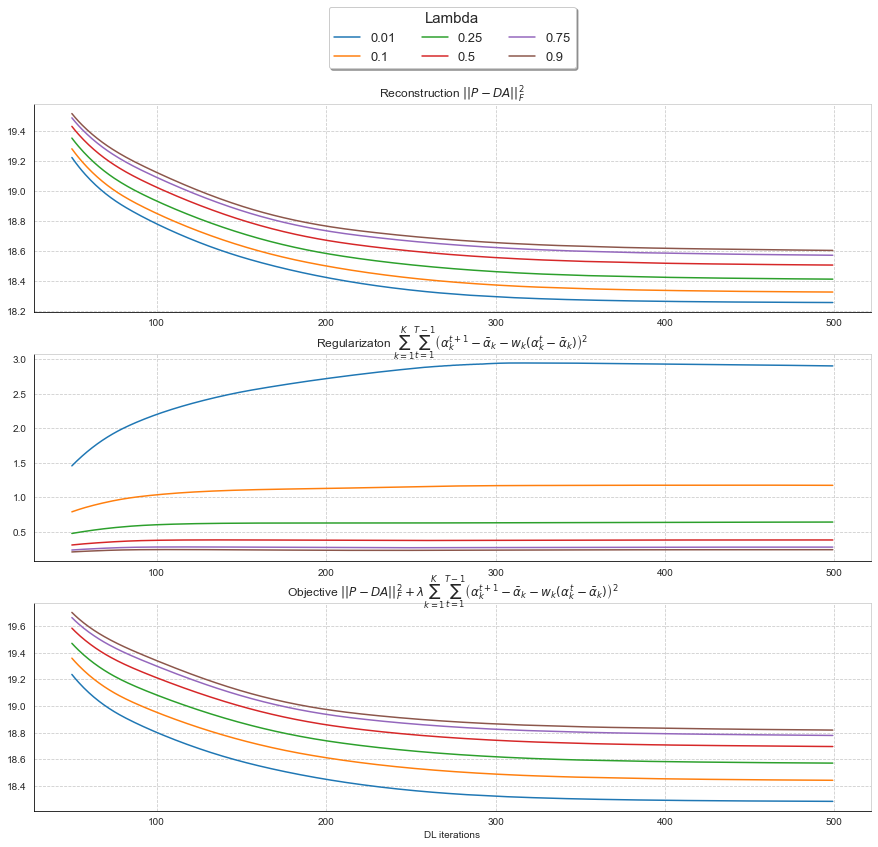

In [27]:
plot_rro(dict_reco_K2, dict_regu_K2, dict_obj_K2, trunc=50)

### Codings

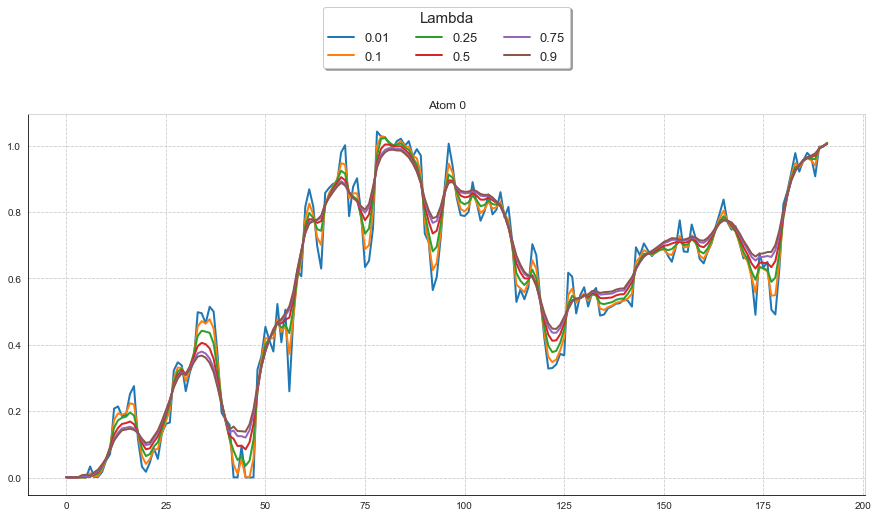

In [28]:
plot_codings_lamb(dict_codings_K2, atom=0)

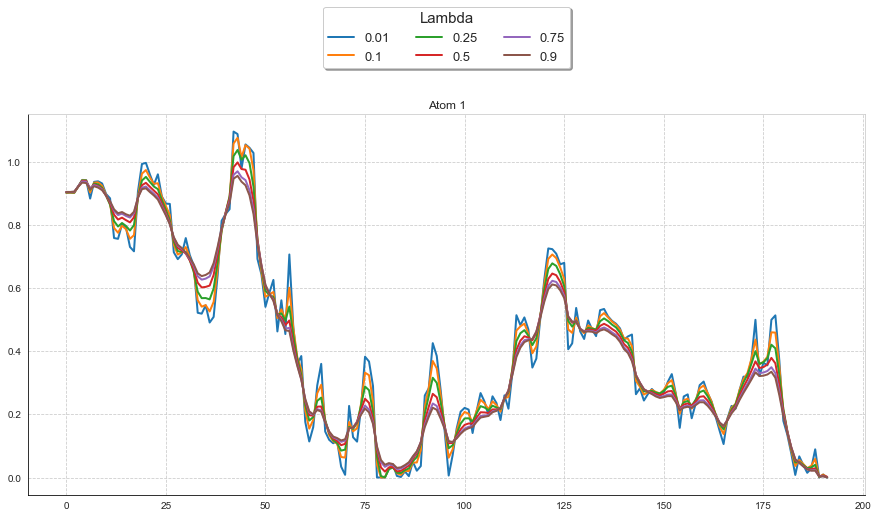

In [29]:
plot_codings_lamb(dict_codings_K2, atom=1)

# Model Selection

In [36]:
IFrame("imgs/mdoel_selection.pdf", width=600, height=600)

In [84]:
df_selection = model_selection(P_train, list_K=[2, 3, 4, 5, 6, 7 , 8 , 9 , 10], 
                               list_lambdas=[0.1, 0.25, 0.5,  0.75, 0.9, 1, 5, 10], 
                                    test_size=0.2, r_dim=11)

/Users/michaelallouche/PhD/repos/dictionary-learning-rmm/dictionary-learning-RMM/models/__init__.py:40: RuntimeWarning: covariance is not positive-semidefinite.
  noise = np.random.multivariate_normal(np.zeros(K), cov, int(n_test) - 1).T


In [85]:
df_selection.astype("float64").round(3)

,0.10,0.25,0.50,0.75,0.90,1.00,5.00,10.00
2,6.680,6.062,5.753,5.631,5.589,5.568,5.393,5.366
3,5.649,5.299,5.028,4.924,4.888,4.869,4.148,4.430
4,5.484,5.034,4.710,4.562,4.500,4.466,3.959,3.711
5,4.709,4.242,3.964,3.872,3.838,3.777,3.635,3.635
6,4.568,4.193,3.991,3.899,3.854,3.828,3.866,3.718
7,4.442,4.081,3.515,3.250,3.145,3.087,2.380,2.452
8,4.843,4.154,3.550,3.159,3.008,2.925,2.326,2.465
9,4.783,3.966,3.030,2.797,3.017,2.997,2.134,2.356
10,4.507,3.242,2.736,2.339,2.273,2.228,1.853,2.178


In [87]:
#df_selection.to_csv("ckpt/model_selection.csv")

# Regularization benefit

In [92]:
N_MAT = P.shape[1]
n_test = int(0.2 * N_MAT)
P_test = P[:, -int(n_test):]
n_train = int(N_MAT-n_test)
P_train = P[:, :int(N_MAT-n_test)]

K = 10
LAMB = 5

In [ ]:
A_test_noreg, A_pred_noreg, A_test_reg, A_pred_reg = regularization_benefit(P_train=P_train,
                                                                           P_test=P_test,
                                                                           K=K, lamb=LAMB)

In [ ]:
# compute the errors without the first testing values
error_reg = np.linalg.norm(A_test_reg[:, 1:] - A_pred_reg) ** 2
error_noreg = np.linalg.norm(A_test_noreg[:, 1:] - A_pred_noreg) ** 2

print("SFro error REG: {:.3f}".format(error_reg))
print("SFro error NO-REG: {:.3f}".format(error_noreg))

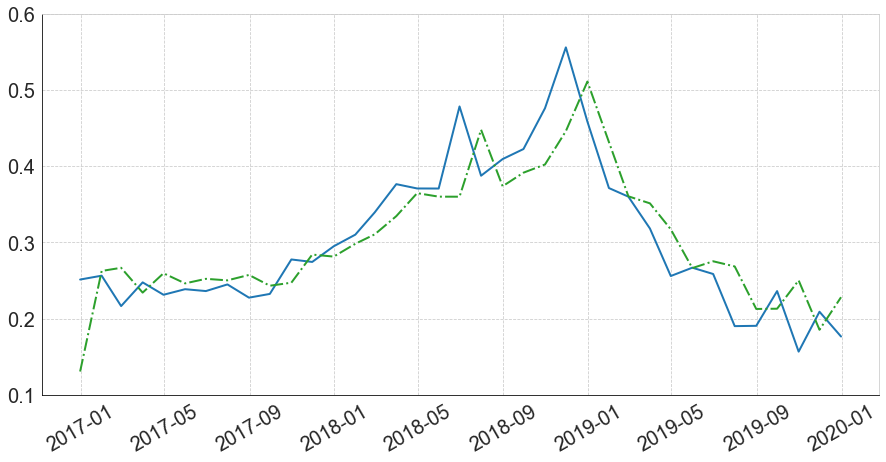

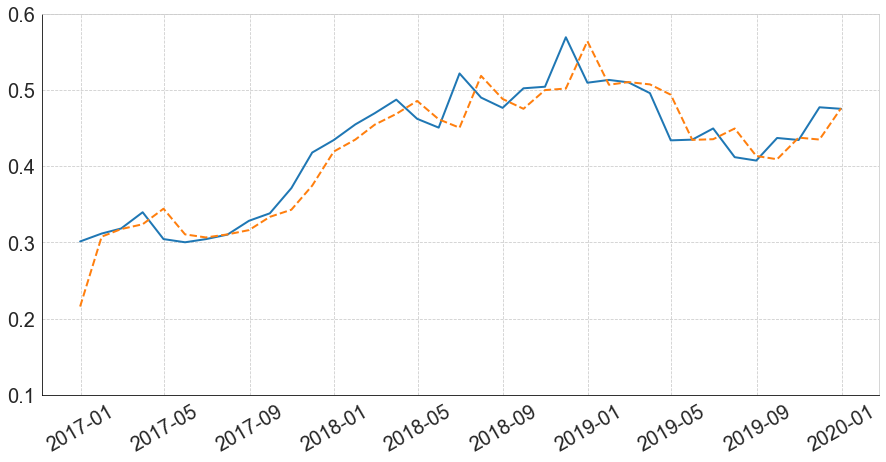

In [44]:
ATOM = 1

# NO REG
# -------
fig, ax = plt.subplots(1, 1, figsize=(15, 7), sharex=True)
ax.plot(dates[n_train+1:], A_test_noreg[ATOM-1, 1:], label="test", linewidth=2)
ax.plot(dates[n_train+1:], A_pred_noreg[ATOM-1, :], label="no_reg", linewidth=2, color="C2",  linestyle="-.")

ax.spines["left"].set_color("black")
ax.spines["bottom"].set_color("black")

ax.set_ylim(0.1, 0.6)

_=plt.xticks(fontsize=20, rotation=30)
_=plt.yticks(fontsize=20)

#_=plt.legend()
#plt.savefig("imgs/prediction/noreg-K{}-lamb{}-atom{}.eps".format(K, 0, ATOM)
# ----------


# REG
# -------

fig, ax = plt.subplots(1, 1, figsize=(15, 7), sharex=True)
ax.plot(dates[n_train+1:], A_test_reg[ATOM-1, 1:], label="test", linewidth=2)
ax.plot(dates[n_train+1:], A_pred_reg[ATOM-1, :], label="reg", linewidth=2, linestyle="--")

ax.spines["left"].set_color("black")
ax.spines["bottom"].set_color("black")

ax.set_ylim(0.1, 0.6)

_=plt.xticks(fontsize=20, rotation=30)
_=plt.yticks(fontsize=20)

#_=plt.legend()
#plt.savefig("imgs/prediction/reg-K{}-lamb{}-atom{}.eps".format(K, LAMB, ATOM))
# -------

# Comparaison AR and DL

In [46]:
# build train set
model = DictionaryLearning(K=K, r_dim=11)
model.fit(P_train, lamb=LAMB, max_iter=500)

In [49]:
# fit AR model on the training codings A_train
list_paramsAR= []  
for atom in range(K):
    ar_model = AutoReg(model.A[atom, :], lags=1).fit()
    list_paramsAR.append(ar_model.params)

mat_paramsAR = np.array(list_paramsAR)
mat_paramsDL = np.concatenate([model.mu.reshape(-1,1), model.W.reshape(-1,1)], axis=1)

In [66]:
# Difference between parameters AR and DL
pd.DataFrame(mat_paramsDL-mat_paramsAR, columns=["constant", "drift"])

,constant,drift
0,-0.000759,0.000038
1,-0.000792,-0.000107
2,0.000197,-0.000011
3,-0.001999,-0.000315
4,0.000399,-0.000044
5,0.000453,-0.000025
6,0.002363,-0.000008


# Dictionary

In [70]:
for atom in range(1, K+1):
    display(Latex("$d_{}$".format(atom)))
    display(pd.DataFrame(model.inv_vectorized(model.D[:, atom-1], 10, 11)).round(4)*100)

<IPython.core.display.Latex object>

,0,1,2,3,4,5,6,7,8,9,10
0,99.91,0.00,0.00,0.00,0.00,0.00,0.06,0.00,0.01,0.00,0.01
1,0.01,96.15,3.75,0.00,0.00,0.00,0.07,0.00,0.01,0.00,0.01
2,0.01,0.05,93.22,5.31,1.32,0.00,0.07,0.00,0.01,0.00,0.01
3,0.01,0.05,0.56,93.80,4.41,1.00,0.15,0.00,0.01,0.01,0.01
4,0.01,0.05,0.56,0.03,89.07,7.19,1.75,0.84,0.48,0.01,0.01
5,0.01,0.05,0.56,0.03,2.78,88.28,6.75,0.88,0.64,0.00,0.01
6,0.01,0.05,0.19,0.41,0.00,2.36,88.53,6.46,1.98,0.00,0.01
7,0.01,0.05,0.12,0.14,0.34,0.78,11.61,83.00,3.95,0.00,0.01
8,0.00,0.04,0.04,0.22,0.17,0.51,1.77,14.50,82.73,0.00,0.01
9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,99.99,0.01


<IPython.core.display.Latex object>

,0,1,2,3,4,5,6,7,8,9,10
0,100.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0
1,6.51,92.10,1.02,0.14,0.23,0.00,0.00,0.00,0.00,0.00,0.0
2,0.31,16.88,82.43,0.00,0.38,0.00,0.00,0.00,0.00,0.00,0.0
3,0.31,0.00,21.96,77.35,0.00,0.30,0.01,0.02,0.02,0.03,0.0
4,0.31,0.00,3.06,17.74,78.19,0.62,0.00,0.01,0.00,0.07,0.0
5,0.17,0.13,0.40,1.45,18.51,73.07,2.16,3.26,0.00,0.84,0.0
6,0.17,0.14,0.40,0.44,2.04,21.82,68.62,5.09,0.45,0.84,0.0
7,0.16,0.14,0.40,0.44,2.05,4.75,8.82,77.24,1.80,4.20,0.0
8,0.16,0.14,0.07,0.01,2.80,4.75,0.00,0.00,76.00,16.06,0.0
9,0.00,0.00,0.00,0.00,0.67,0.84,6.43,0.00,76.00,16.06,0.0


<IPython.core.display.Latex object>

,0,1,2,3,4,5,6,7,8,9,10
0,29.84,49.01,6.67,5.43,1.17,6.48,0.00,0.00,0.00,0.00,1.41
1,0.00,78.85,2.25,8.72,2.29,2.81,1.22,0.85,0.84,0.76,1.41
2,0.00,2.52,68.46,16.55,4.59,2.81,1.22,0.85,0.84,0.76,1.41
3,0.00,1.81,6.35,65.54,16.80,4.42,1.22,0.85,0.84,0.77,1.41
4,0.00,0.74,0.58,4.72,78.59,8.09,2.92,1.34,0.75,0.86,1.41
5,0.00,0.36,0.97,2.14,4.25,74.13,11.18,1.87,1.37,1.48,2.25
6,0.00,0.35,0.33,0.43,1.08,3.94,84.34,4.14,1.15,1.17,3.07
7,0.00,0.34,0.33,0.43,1.08,0.00,0.00,87.47,2.59,2.24,5.52
8,0.00,0.05,0.00,0.00,0.00,2.13,0.00,6.88,0.00,45.15,45.78
9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,54.22,45.78


<IPython.core.display.Latex object>

,0,1,2,3,4,5,6,7,8,9,10
0,100.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.0,62.12,32.77,5.10,0.01,0.00,0.00,0.00,0.00,0.00,0.00
2,0.0,0.00,90.07,9.91,0.00,0.02,0.00,0.00,0.00,0.00,0.00
3,0.0,0.00,5.77,70.06,21.36,1.72,1.09,0.00,0.00,0.00,0.00
4,0.0,0.00,0.34,22.08,61.74,12.59,1.48,0.26,0.00,1.29,0.21
5,0.0,0.00,0.33,2.95,22.19,50.80,18.05,0.59,0.60,1.12,3.36
6,0.0,0.00,0.28,0.67,4.88,20.81,46.78,18.37,3.42,1.04,3.75
7,0.0,0.00,0.28,0.03,0.46,4.51,44.26,17.49,14.50,7.34,11.13
8,0.0,0.00,0.27,0.04,0.46,0.00,9.41,15.16,0.00,19.38,55.29
9,0.0,0.00,0.00,0.00,0.00,0.00,10.17,0.00,0.00,34.54,55.29


<IPython.core.display.Latex object>

,0,1,2,3,4,5,6,7,8,9,10
0,74.47,19.71,2.93,0.00,0.02,1.64,0.00,0.00,0.00,0.00,1.22
1,0.00,94.18,2.93,0.00,0.02,0.00,0.36,0.41,0.45,0.43,1.22
2,0.00,0.96,65.99,19.47,8.78,1.93,0.36,0.41,0.44,0.43,1.22
3,0.00,0.04,0.00,81.33,11.66,4.05,0.41,0.41,0.40,0.48,1.22
4,0.00,0.04,0.00,0.00,75.76,14.63,7.06,0.42,0.00,0.88,1.22
5,0.00,0.00,0.00,0.04,0.00,86.17,9.44,1.93,0.26,0.94,1.22
6,0.00,0.00,0.00,0.00,0.00,8.46,78.98,10.14,0.00,0.00,2.42
7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,97.58,0.00,0.00,2.42
8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,97.58,0.00,2.42
9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,100.00


<IPython.core.display.Latex object>

,0,1,2,3,4,5,6,7,8,9,10
0,97.53,2.47,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0
1,0.00,87.94,12.06,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0
2,0.00,6.38,90.42,0.00,2.33,0.86,0.00,0.00,0.0,0.0,0.0
3,0.00,3.50,8.61,82.35,4.41,1.13,0.00,0.00,0.0,0.0,0.0
4,0.00,1.01,0.43,17.22,72.17,9.17,0.00,0.00,0.0,0.0,0.0
5,0.00,0.26,1.18,1.38,16.43,71.78,7.13,1.83,0.0,0.0,0.0
6,0.00,0.25,0.34,0.83,2.89,14.56,78.69,2.43,0.0,0.0,0.0
7,0.00,0.25,0.33,0.84,1.41,0.89,18.55,77.72,0.0,0.0,0.0
8,0.00,0.00,0.00,0.00,0.00,2.78,19.50,77.72,0.0,0.0,0.0
9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,100.00,0.0,0.0,0.0


<IPython.core.display.Latex object>

,0,1,2,3,4,5,6,7,8,9,10
0,69.37,17.72,0.38,10.12,0.33,0.00,0.91,1.16,0.00,0.00,0.0
1,8.01,69.30,10.17,5.06,1.86,3.24,1.21,1.16,0.00,0.00,0.0
2,3.28,23.52,44.37,18.96,3.28,4.23,1.20,1.16,0.00,0.00,0.0
3,1.15,3.94,27.13,48.91,8.50,8.00,1.20,1.17,0.00,0.00,0.0
4,0.56,0.88,4.08,26.58,48.84,15.32,2.55,1.17,0.00,0.00,0.0
5,0.56,0.79,0.22,4.81,21.74,63.21,6.80,1.84,0.00,0.00,0.0
6,0.56,0.67,0.35,0.88,4.28,18.75,65.58,8.94,0.00,0.00,0.0
7,0.56,0.41,0.17,0.28,0.48,3.57,6.87,87.65,0.00,0.00,0.0
8,0.00,0.00,0.00,0.00,0.00,0.00,12.35,0.00,87.65,0.00,0.0
9,0.00,0.00,0.00,0.00,0.00,0.00,12.35,0.00,0.00,87.65,0.0


# Clustering (K-Means)

In [71]:
# Model
n_test = int(0.2 * N_MAT)
P_test = P[:, -int(n_test):]
n_train = int(N_MAT-n_test)
P_train = P[:, :int(N_MAT-n_test)]
K = 7
LAMB = 0.7

# build train model
model = DictionaryLearning(K=K, r_dim=11)
model.fit(P_train, lamb=LAMB, max_iter=500)

In [72]:
# projection of P^test on D^train
A_test = np.linalg.inv(model.D.T @ model.D) @ model.D.T @ P_test  # real
# Predicitoin of codings
A_pred = model.mu.reshape(-1, 1) + (model.W.reshape(-1, 1) * A_test[:, :-1])

In [74]:
# Stadardization of training codings
A_mean = model.A.mean(axis=1).reshape(-1,1)
A_std = model.A.std(axis=1).reshape(-1,1)
A_scaled = ((model.A - A_mean) / A_std).T

In [ ]:
def plot_3Clusters(X):
    fig, ax = plt.subplots(1, 1, figsize=(12,7))
    print(X.shape)

    ax.scatter(dates[:n_train][np.where(X == 2)[0]], 
                -1*np.ones_like(np.where(X == 2)[0]), 
                color="orange")

    ax.scatter(dates[:n_train][np.where(X == 1)[0]], 
                -1*np.ones_like(np.where(X == 1)[0]), 
                color="red")

    ax.scatter(dates[:n_train][np.where(X == 0)[0]], 
                np.ones_like(np.where(X == 0)[0]), 
                color="green")

    ax.spines["left"].set_color("black")
    ax.spines["bottom"].set_color("black")

    plt.xlabel("time", fontsize=20)
    plt.ylabel("Clustering", fontsize=20)
    return

In [75]:
N_CLUSTERS = 3
# Fit Kmean
kmeans = KMeans(
     init="random",
     n_clusters=N_CLUSTERS,
     n_init=10,
     max_iter=300,
     random_state=42)

kmeans.fit(A_scaled)

KMeans(init='random', n_clusters=3, random_state=42)

In [ ]:
plt.figure(figsize=(12,7))
fig, ax = plt.subplots(1, 1, figsize=(12,7))

ax.scatter(dates[:n_train][np.where(y_train_pred == 2)[0]], 
            -1*np.ones_like(np.where(y_train_pred == 2)[0]), 
            color="orange")

ax.scatter(dates[:n_train][np.where(y_train_pred == 1)[0]], 
            -1*np.ones_like(np.where(y_train_pred == 1)[0]), 
            color="red")

ax.scatter(dates[:n_train][np.where(y_train_pred == 0)[0]], 
            np.ones_like(np.where(y_train_pred == 0)[0]), 
            color="green")

ax.spines["left"].set_color("black")
ax.spines["bottom"].set_color("black")

plt.xlabel("time", fontsize=20)
plt.ylabel("Clustering", fontsize=20)
#_ = plt.title("Clustering of the Train set", fontsize="20")

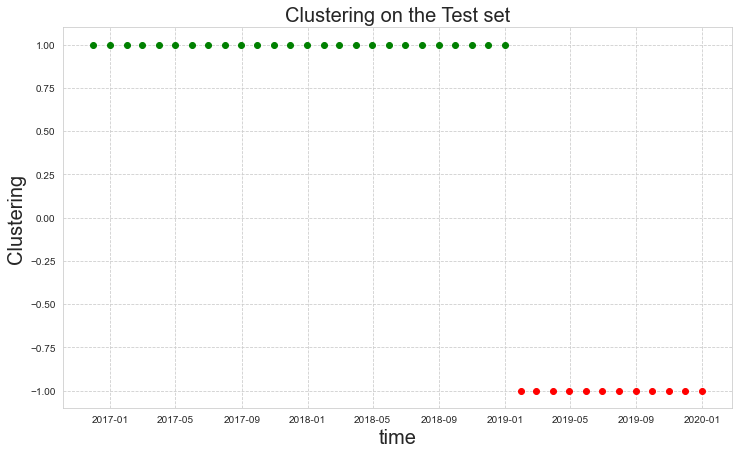

In [147]:
# clustering prediction on AR predictions
A_test_scaled = (A_test - A_mean) / A_std
y_test_pred = kmeans.predict(A_test_scaled.T)

plt.figure(figsize=(12,7))
plt.scatter(dates[n_train:][np.where(y_test_pred == 1)[0]], 
            -1*np.ones_like(np.where(y_test_pred == 1)[0]), 
            color="red")

plt.scatter(dates[n_train:][np.where(y_test_pred == 0)[0]], 
            np.ones_like(np.where(y_test_pred == 0)[0]), 
            color="green")
plt.xlabel("time", fontsize=20)
plt.ylabel("Clustering", fontsize=20)
_ = plt.title("Clustering on the Test set", fontsize="20")

## M=3

In [34]:
# Fit Kmean
kmeans = KMeans(
     init="random",
     n_clusters=3,
     n_init=10,
     max_iter=300,
     random_state=42)

kmeans.fit(A_scaled)

# Final locations of the centroids
kmeans.cluster_centers_

array([[-0.02069793, -0.51454574,  1.12593244, -0.50442275, -0.32375083,
         0.83550232, -0.49292826],
       [-0.68812405, -0.29003689, -0.51343304, -0.4848529 ,  0.64040817,
        -0.45109479,  1.18778775],
       [ 0.55674363,  0.60780867, -0.42659301,  0.75363874, -0.26509516,
        -0.26139433, -0.57101706]])

In [35]:
# Final predictions
y_train_pred = kmeans.labels_
y_train_pred

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2,
       2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
      dtype=int32)

Train


<Figure size 864x504 with 0 Axes>

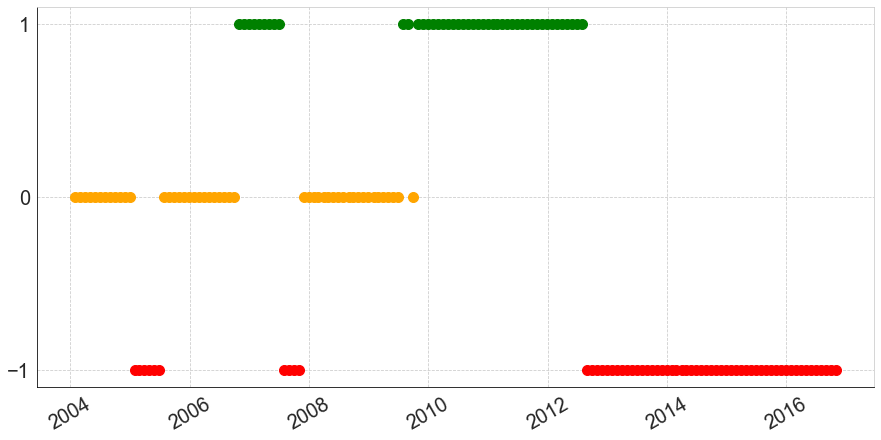

In [36]:
plt.figure(figsize=(12,7))
fig, ax = plt.subplots(1, 1, figsize=(15,7),)

ax.scatter(dates[:n_train][np.where(y_train_pred == 2)[0]], 
            -1*np.ones_like(np.where(y_train_pred == 2)[0]), 
            color="red", s=100)

ax.scatter(dates[:n_train][np.where(y_train_pred == 1)[0]], 
            np.zeros_like(np.where(y_train_pred == 1)[0]), 
            color="orange", s=100)

ax.scatter(dates[:n_train][np.where(y_train_pred == 0)[0]], 
            np.ones_like(np.where(y_train_pred == 0)[0]), 
            color="green", s=100)

ax.spines["left"].set_color("black")
ax.spines["bottom"].set_color("black")

_=plt.xticks(fontsize=20, rotation=30)
_=plt.yticks(fontsize=20)

ax.set_yticks([-1, 0 , 1])

print("Train")
#plt.savefig("imgs/prediction/cluster_train-K{}-lamb{}-atom{}.eps".format(K, LAMB, ATOM))
#plt.xlabel("time", fontsize=20)
#plt.ylabel("Clustering", fontsize=20)
#_ = plt.title("Clustering on the Train set", fontsize="20")

Test


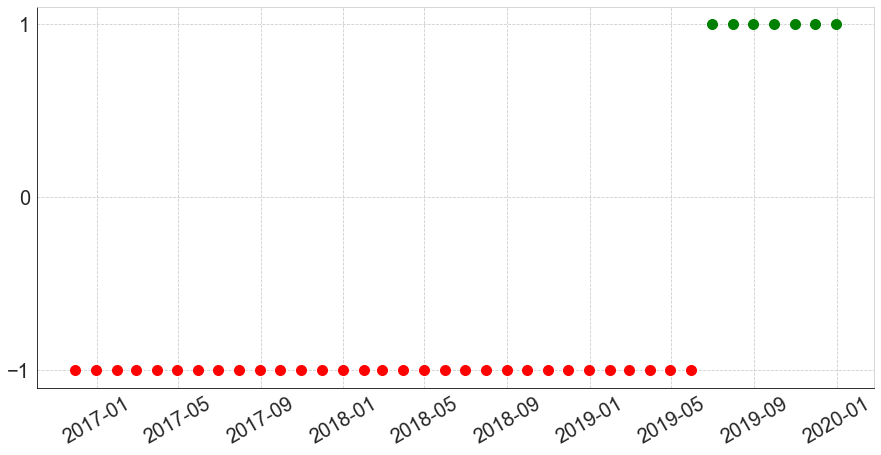

In [37]:
# clustering prediction on AR predictions
A_test_scaled = (A_test - A_mean) / A_std
y_test_pred = kmeans.predict(A_test_scaled.T)

fig, ax = plt.subplots(1, 1, figsize=(15,7),)
plt.scatter(dates[n_train:][np.where(y_test_pred == 2)[0]], 
            -1*np.ones_like(np.where(y_test_pred == 2)[0]), 
            color="red", s=100)

ax.scatter(dates[n_train:][np.where(y_test_pred == 1)[0]], 
            np.zeros_like(np.where(y_test_pred == 1)[0]), 
            color="orange", s=100)

ax.scatter(dates[n_train:][np.where(y_test_pred == 0)[0]], 
            np.ones_like(np.where(y_test_pred == 0)[0]), 
            color="green", s=100)


ax.spines["left"].set_color("black")
ax.spines["bottom"].set_color("black")

_=plt.xticks(fontsize=20, rotation=30)
_=plt.yticks(fontsize=20)

ax.set_yticks([-1, 0 , 1])

print("Test")
#plt.savefig("imgs/prediction/cluster_test-K{}-lamb{}-atom{}.eps".format(K, LAMB, ATOM))

#plt.xlabel("time", fontsize=20)
#plt.ylabel("Clustering", fontsize=20)
#plt.ylim(-1.1, 1.1)
#_ = plt.title("Clustering on the Test set", fontsize="20")

## Study the associated atoms

$$\bar\alpha^{{red}}_k = \frac{1}{T^{red}}\sum_{t=1}^{T^{red}}\alpha_k^t$$


In [42]:
LABEL = 1
cluster_times = np.where(y_train_pred == LABEL)[0]
cluster_times

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 18, 19, 20, 21, 22,
       23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 46, 47, 48, 49, 50, 51, 52,
       53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 68])

In [43]:
# average of codings alpha
alpha_avg = model.A[:, cluster_times].mean(axis=1) #.round(1)
alpha_avg

array([0.28911065, 0.064022  , 0.03711528, 0.07305504, 0.13067048,
       0.03805481, 0.37557592])

In [41]:
# dictionary
for atom in range(K):
    display(Latex("$\check d{}$".format(atom+1)))
    display(pd.DataFrame(model_train.inv_vectorized(model_train.D[:, atom], 10, 11)).round(4)*100)

,0,1,2,3,4,5,6,7,8,9,10
0,100.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0
1,0.0,98.48,1.44,0.00,0.08,0.00,0.00,0.00,0.00,0.00,0.0
2,0.0,0.00,94.42,4.78,0.80,0.00,0.00,0.00,0.00,0.00,0.0
3,0.0,0.00,0.01,97.86,2.11,0.00,0.01,0.00,0.00,0.01,0.0
4,0.0,0.00,0.01,0.00,92.23,5.50,1.42,0.56,0.26,0.01,0.0
5,0.0,0.00,0.01,0.00,1.54,91.29,4.96,1.51,0.68,0.01,0.0
6,0.0,0.00,0.00,0.01,0.00,2.36,89.43,6.26,1.93,0.01,0.0
7,0.0,0.00,0.00,0.00,0.01,0.01,11.18,84.98,3.80,0.01,0.0
8,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,99.98,0.01,0.0
9,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,100.00,0.0


In [ ]:
# Cluster RED
atoms = ["Atom {}".format(k) for k in np.arange(1, 7)]
fig, ax = plt.subplots(figsize=(10, 10))
explode = (0, 0, 0.1, 0, 0.1, 0)  # explode 1st slice
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue', 'lightpink', "lightgray"]

ax.pie(alpha_avg, labels=atoms, explode=explode, autopct='%.1f%%',
       colors=colors, shadow=True, startangle=90, textprops={'fontsize': 19}) # 

_=plt.axis('equal')
#plt.savefig("imgs/experiments/pie_train-group{}.eps".format(LABEL), format="eps")